<a href="https://colab.research.google.com/github/lfernandof/lfp_signals_analysis/blob/main/consistency_check_sqi_analyses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spike sequentiality and neural sequence occurrence analysis

Based on the technique introduced in:

**Zhou** S, **Masmanidis** SC, **Buonomano** DV. *Neural Sequences as an Optimal Dynamical Regime for the Readout of Time.* **Neuron**. 2020 Nov 25;108(4):651-658.e5. doi: 10.1016/j.neuron.2020.08.020. Epub 2020 Sep 17. PMID: 32946745; PMCID: PMC7825362.

Applied to our data, reported in the following publication:

**Tunes** GC, **Fermino de Oliveira** E, **Vieira** EUP, **Caetano** MS, **Cravo** AM, **Bussotti Reyes** M. *Time encoding migrates from prefrontal cortex to dorsal striatum during learning of a self-timed response duration task*. **Elife**. 2022 Sep 28;11:e65495. doi: 10.7554/eLife.65495. PMID: 36169996; PMCID: PMC9519146.

**Results summary**:


*   No significant difference in the sequentiality index in our data, either between regions (prefrontal cortex, PFC; and striatum, STR), training session moment (early in training or late in training) and across days (day 1, day 2);
*   A statistically significant change in peak entropy between early and late in day 1 in the prefrontal cortex
*   There are neural sequences both early and late in session but the peak latency profile changes, i.e. if one orders peak latency early in session this ordering would not be preserved by late session, but a new one emerges



# Imports, data and settings

In [1]:
############### Data #######################
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy import stats
from scipy import signal as sig
import os
import random
from itertools import combinations

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#Go to the folder with all things relevant
os.chdir('/content/drive/MyDrive/backup-mac/ufabc/entire-backup/sqi/corrected_2023/')

data = pd.read_csv('./data/data_electrophysiology.csv').copy()
results_folder_path = './results/'

In [3]:
#Plotting settings:
plt.rcParams.update({'font.size': 16})

# Functions to estimate the SqI

In [7]:
def separate_rats(dataframe,check_num_neurons=True,min_num_neurons = 2):
    #Separate the dataframe by rat, and store each part as an entry in a list

    # INPUT:
    # - dataframe
    # - check_num_neurons: check whether a rat in this dataframe has less than min_num_neurons (default: True)
    # - min_num_neurons: the least amount of neurons an animal has to have in order to be included (default: 2)

    # OUTPUT:
    # - rats: a list of DataFrames, each entry being the subset of the main DataFrame with the spikes from one rat

    rats = []
    for rat in dataframe['rat'].unique():

        #Check whether a rat has only one registered neuron in the dataset
        if check_num_neurons:
            if dataframe.loc[dataframe['rat']==rat].neuron.nunique() < min_num_neurons:
                #If it's less than min_num_neurons, skip to the next animal
                continue
            #If one's not checking (check_num_neurons = False) or the animal has sufficient neurons, save it
        rats.append(dataframe.loc[dataframe['rat'] == rat])
    return rats #an array of dataframes (!)

def estimate_sqi(binned_spikes,num_entropic_bins=15,mean_over_trials=True):

    #Estimate the Sequentiality Index (SqI) as defined in [1] for N neurons over M trials

    #Python version of the code originally written in Matlab by Dean Buonomano and Shanglin Zhou in 9/14/2019
    #Original available at: github.com/ShanglinZhou/M2_DLS_2Intervals

    # INPUT:
    # - convolved_spikes [np.ndarray (int,int,int)]: a trials x neurons x timebins matrix with the normalised firing rate (convolved & normalised spike trains) for each neuron at each trial
    # - num_entropic_bins [int]: Number of timebins to estimate the Peak Entropy. For more details check the paper. (default: 15)
    # - mean_over_trials: whether the entropic estimates (SqI, PE, TS) should be averaged over all trials (default: True, as in the original paper)

    # OUTPUT:
    # - entropic_variables [list (tuples (float)) or tuple (float)]: if mean_over_trials, a tuple of floats representing respectively the SqI, PE and TS.
                                                                  #  else, a list of tuples with these variables at each trial

    #[1] Zhou et al., Neural Sequences as an Optimal Dynamical Regime for the Readout of Time, Neuron (2020), https:// doi.org/10.1016/j.neuron.2020.08.020

    trials,num_neurons,timebins = np.shape(binned_spikes)
    binsize = timebins/(num_entropic_bins - 1)

    #To store the results
    entropic_variables = np.zeros([trials,3])

    for current_trial in range(trials):
        #Calculating the Peak Entropy (PE):

        #peak times: the time bin in which each unit reaches its greatest value
        peaktimes = np.argmax(binned_spikes[current_trial],axis=1)

        #build the entropic bins in which the peaks will be counted
        centers_arange = np.arange(start=0-binsize/2,stop=timebins+binsize/2,step=binsize)
        '''The MATLAB hist() function bins the histogram around the centers. In order to implement a version of it
        in Python using numpy's histogram() function, I had to position the leftmost edge half a binsize before 0,
        and the last one half binsize after 1500, accounting for (N+1) edges, where N is the number of intended
        bins passed in MATLAB, so that upon calculating the histogram the number of bins of these two and the
        points within each timespan would be the same'''

        #how many neurons peak per entropic bin:
        n,edges = np.histogram(np.argmax(binned_spikes[current_trial],axis=1),centers_arange)

        #the probability of peak in each bin is the number of peaks in that bin (n)
        #divided by the total number of units
        probpeak = np.divide(n,num_neurons)

        #remove non-spiking bins from calculation (they'd contribute nothing for p_j = 0,
        #but computationally would yield problems upon feeding p_j = 0 into the np.log2() function)
        probpeak = probpeak[probpeak>0]

        #sum the entropic contributions
        pe = np.sum(-probpeak*np.log2(probpeak))

        #and normalise
        pe = pe/np.log2(num_entropic_bins) #normalised peak entropy for this trial

        #Calculating the Temporal Sparsity (TS):
        #normalise each neuron's activity by the spikes of all neurons in that timebin
        #(summed values for the column with sum())
        dn = np.divide(binned_spikes[current_trial],sum(binned_spikes[current_trial]))

        '''This accounts for a "probability distribution" of sorts, for it attends to all Kolmogorov axioms:
        - All entries are non-negative;
        - No entry exceeds 1;
        - The compound entry for disjoint events (say, different neurons' activities in a timebin) equals the
        sum of individual entries for each event'''

        #sum the entropic contribution of each neuron over time in the population
        ts = np.nansum(np.multiply(-dn,np.log2(dn)),axis=0)

        #mean in the time dimension
        ts = np.mean(ts)

        #normalise by the number of neurons and subtract from 1
        ts = 1 - ts/np.log2(num_neurons)

        #the sqi is the geometric mean of these values:
        sqi = np.sqrt(pe*ts)

        entropic_variables[current_trial] = [sqi,pe,ts]

    if mean_over_trials:
      #take the mean over all trials
      sqi = np.mean(entropic_variables,axis=0)[0]
      pe = np.mean(entropic_variables,axis=0)[1]
      ts = np.mean(entropic_variables,axis=0)[2]
      return sqi,pe,ts

    else:
      return entropic_variables

def time_binning(spikes_df,timespan=[0,1.5]):

  #Transform the spikes DataFrame into a 3D np.ndarray whose dimensions are (trials,neurons,timebins)

  # INPUT:
  # - dataset [pandas DataFrame]
  # - timespan [list(float)]: the timestamp boundaries in which all spikes to be binned lie within (in s; default = [0s,1.5s])

  # OUTPUT:
  # - binned_spikes: a trials x neurons x timebins matrix

  #just in case the dataset is not sorted by trial
  dataset = spikes_df.sort_values('trial').copy()

  num_trials = dataset.trial.nunique()
  num_neurons = dataset.neuron.nunique()

  duration = timespan[1] - timespan[0]
  num_timebins = int(duration*1000)

  binned_spikes_matrix = np.zeros([num_trials,num_neurons,num_timebins])

  for trial_id,trial in enumerate(dataset.trial.unique()):
    for neuron_id,neuron in enumerate(dataset.neuron.unique()):
      spike_train = dataset.loc[(dataset['trial'] == trial) & (dataset['neuron'] == neuron)]
      discretized_spike_train,edges = np.histogram(spike_train.time,bins = np.linspace(timespan[0],timespan[1],num_timebins+1,endpoint=True))
      binned_spikes_matrix[trial_id,neuron_id,:] = discretized_spike_train

  return binned_spikes_matrix

def convolve_raster(binned_spikes):
    #Convolve a matrix containing the raster plots (time histogram of spikes) for all neurons in all trials

    #INPUT:
    # - binned_spikes: a trials x neurons x timebins matrix
    # - width: the kernel width, in ms
    # - sd: I haven't figured it out exactly yet: lower values widen the kernel shape and larger ones sharpen it
    #the authors didn't call it SD, I am extrapolating from my knowledge on gaussian filtering (might be wrong)

    #OUTPUT:
    # - convolved [np.ndarray(int,int,float)]: a trials x neurons x timebins matrix of convolved spiking activity

    x = np.linspace(0,750,750) #750 ms in 750 points

    kernel = np.exp(-x/100)
    kernel = np.pad(kernel,(750,0),'constant') #center the kernel at 0

    #uncomment these to plot the kernel
    #plt.figure()
    #plt.title('Decaying exponential kernel')
    #plt.plot(np.arange(0,len(x)),decaying_exp)

    #uncomment these to plot evidence that the kernel drops to 1/e over the course of 100ms
    #plt.figure()
    #plt.title('Decaying exponential kernel')
    #plt.plot(np.arange(0,len(x)),decaying_exp)


    #create a matrix with the same dimensions as the binned rasters' to accommodate the convolved rasters
    all_neurons_convolved = np.zeros(np.shape(binned_spikes))
    print(np.shape(all_neurons_convolved))

    #the # of trials, neurons and timebins are given by:
    trials,neurons,timebins = np.shape(binned_spikes)

    for trial in range(trials):
        for neuron in range(neurons):
            all_neurons_convolved[trial,neuron,:] = np.convolve(kernel,binned_spikes[trial,neuron,:]
                                                            ,mode='full')[750:-749]

    return all_neurons_convolved

def normalise_data(rasters):
    # Normalise the firing rates of each neuron by its maximum firing rate

    #INPUT:
    # - rasters: a convolved trials x neurons x timebins matrix

    #OUTPUT:
    # - normalised: the normalised (post-convolution) spike trains in the raster [all firing rates between 0 and 1]

    #######################################################################################################

    trials,neurons,timebins = np.shape(rasters)
    normalised = np.zeros([trials,neurons,timebins])

    for neuron in range(neurons):
        #select the neuron of interest
        current_cell = rasters[:,neuron,:]

        #get the largest and smallest firing rates this neuron has throughout the session
        minimum_fr = current_cell.min()
        maximum_fr = current_cell.max()

        #subtract the mininum fr from all cells and normalised by the greatest difference between firing rates
        normalised_cell = (current_cell - minimum_fr)/(maximum_fr - minimum_fr)

        #just in case of the firing rate being always the same and we try to divide by zero:
        normalised_cell[np.isnan(normalised_cell)] = 0

        #save it onto the matrix
        normalised[:,neuron,:] = normalised_cell

    return normalised

def least_amount_neurons(dataset,num_cells_threshold = 4):
    #Drop trials with less than a given amount of neurons out of the dataset and find the least amount of units among all remaining trials that is not below this threshold

    #INPUT:
    # - dataset: pandas DataFrame [pd.df] (for columns and descriptions: see _specifications_)
    # - num_cells_threshold: the least amount of neurons required for inclusion of that trial

    #OUTPUT:
    # - pruned_dataset: the dataset (pd.df) cleared of the data pertaining to trials with less neurons than needed
    # - min_num_units: the minimum number of neurons all the remaining cells possess

    #Make a copy, so it'll not alter the given dataset
    pruned_dataset = dataset.copy()

    #Set the minimum amount of neurons to a high initial value
    min_num_units = 10_000 #a ludicrous amount of neurons

    #Check each trial for their number of neurons
    for trial in dataset.trial.unique():
        #if it falls below the threshold, remove it from the pruned_dataset
        if dataset.loc[dataset['trial'] == trial].neuron.nunique() < num_cells_threshold:
            pruned_dataset.drop(pruned_dataset.loc[pruned_dataset['trial']==trial].index,inplace=True)
            pass #skip to the next trial, so not to alter min_num_units with this trial

        #if it is not lower than this least amount, check if it is less than what was set to be the minimum so far
        elif dataset.loc[dataset['trial'] == trial].neuron.nunique() < min_num_units:
            min_num_units = dataset.loc[dataset['trial'] == trial].neuron.nunique()

    return pruned_dataset,min_num_units

def least_amount_spikes(dataset,num_spikes_threshold = 4):
    #Drop trials with less than a given amount of spikes out of the dataset

    #INPUT:
    # - dataset: pandas DataFrame [pd.df] (for columns and descriptions: see _specifications_)
    # - num_spikes_threshold: the least amount of neurons required for inclusion of that trial

    #OUTPUT:
    # - pruned_dataset: the dataset (pd.df) cleared of the data pertaining to trials with less spikes than required

    #Make a copy, so it'll not alter the given dataset
    pruned_dataset = dataset.copy()

    #Check each trial for their number of neurons
    for trial in dataset.trial.unique():
        #if it falls below the threshold, remove it from the pruned_dataset
        if len(dataset.loc[dataset['trial'] == trial]) < num_spikes_threshold:
            pruned_dataset.drop(pruned_dataset.loc[pruned_dataset['trial']==trial].index,inplace=True)

    return pruned_dataset

In [8]:
def early_late_entropic_vars_per_rat(separated_rats,group,day,region,num_bins = 15,interest_variable = 'all'):
  if interest_variable == 'sqi':
    position = 0
  elif interest_variable == 'pe':
    position = 1
  elif interest_variable == 'ts':
    position = 2
  elif interest_variable == 'all':
    position = None
  else:
    raise ValueError('Choose a SqI variable out of the following three: "sqi", "pe" or "ts". If all three, pass in "all"')

  entropic_results_early = []
  entropic_results_late = []
  rats_ids = []

  least_amount_of_trials = min([animal.trial.nunique() for animal in separated_rats])
  trials_in_thirds = int(least_amount_of_trials/3)

  for animal in separated_rats:
      #Get the animal's label to later identify it in the DataFrame
      animal_label = animal.rat.unique()[0]
      print('Beginning the analyses for the rat: ',animal_label)

      animal_pruned = least_amount_spikes(animal,num_spikes_threshold=5)
      current_num_neurons = animal_pruned.neuron.nunique()

      print(animal_pruned.trial.nunique())

      binned_spikes = time_binning(animal_pruned)
      convolved_spikes = convolve_raster(binned_spikes)

      norm_first_mean_convolved = normalise_data(np.expand_dims(np.mean(convolved_spikes[0:trials_in_thirds,:,:],axis=0),axis=0))
      norm_last_mean_convolved = normalise_data(np.expand_dims(np.mean(convolved_spikes[-trials_in_thirds:,:,:],axis=0),axis=0))

      entropic_vars_early = estimate_sqi(norm_first_mean_convolved,num_entropic_bins = num_bins,mean_over_trials = False)[0][position]
      entropic_vars_late = estimate_sqi(norm_last_mean_convolved,num_entropic_bins = num_bins,mean_over_trials = False)[0][position]

      print(estimate_sqi(norm_first_mean_convolved))
      print(estimate_sqi(norm_last_mean_convolved))

      entropic_results_early.append(entropic_vars_early)
      entropic_results_late.append(entropic_vars_late)

      rats_ids.append(animal_label)

  early_tags = ['early' for i in range(len(separated_rats))]
  late_tags = ['late' for i in range(len(separated_rats))]

  all_tags = early_tags+late_tags

  if interest_variable == "all":
    print(entropic_results_early)
    sqis = ([element[0][0] for element in entropic_results_early] + [element[0][0] for element in entropic_results_late])
    pes = ([element[0][1] for element in entropic_results_early] + [element[0][1] for element in entropic_results_late])
    tss = ([element[0][2] for element in entropic_results_early] + [element[0][2] for element in entropic_results_late])

    df = pd.DataFrame({'sqi':sqis,'pe':pes,'ts':tss,'animal_id':rats_ids*2,'session_part':all_tags,'group':group,'day':day,'region':region})

  else:
    df = pd.DataFrame({interest_variable:entropic_results_early+entropic_results_late,'animal_id':rats_ids*2,'session_part':all_tags,'group':group,'day':day,'region':region})

  return df

# Estimating the SqI/PE/TS

No need to run this. I ran beforehand and saved the file. In the following section (*Plotting the results*) there is a cell loading it into a pandas DataFrame for further use.

In [ ]:
def query_session(spikes_dataframe,group,day,region,filter_trials_between=[1.5,3.5],peri_trial_interval=-0.5):
  data_subset = spikes_dataframe.query(f'group == {group} and day == {day} and region == "{region}" and duration >= {filter_trials_between[0]} and duration <= {filter_trials_between[1]}' +
                                       f'and time >= {peri_trial_interval} and time <= {filter_trials_between[0]}').copy()

  return data_subset

######## Group 1, day 1 ###########

separated_rats = separate_rats(query_session(data,group=1,day=1,region='PFC'),check_num_neurons=True,min_num_neurons = 4)
g1d1_PFC = early_late_entropic_vars_per_rat(separated_rats,group=1,region='PFC',day=1,interest_variable='all')

######## Group 2, day 1 ###########
separated_rats = separate_rats(query_session(data,group=2,day=1,region='PFC'),check_num_neurons=True,min_num_neurons = 4)
g2d1_PFC = early_late_entropic_vars_per_rat(separated_rats,group=2,region='PFC',day=1,interest_variable='all')

separated_rats = separate_rats(query_session(data,group=2,day=1,region='STR'),check_num_neurons=True,min_num_neurons = 4)
g2d1_STR = early_late_entropic_vars_per_rat(separated_rats,group=2,region='STR',day=1,interest_variable='all')


######## Group 2, day 2 ###########
separated_rats = separate_rats(query_session(data,group=2,day=2,region='PFC'),check_num_neurons=True,min_num_neurons = 4)
g2d2_PFC = early_late_entropic_vars_per_rat(separated_rats,group=2,region='PFC',day=2,interest_variable='all')

separated_rats = separate_rats(query_session(data,group=2,day=2,region='STR'),check_num_neurons=True,min_num_neurons = 4)
g2d2_STR = early_late_entropic_vars_per_rat(separated_rats,group=2,region='STR',day=2,interest_variable='all')

Beginning the analyses for the rat:  7
603
(603, 17, 1500)


<ipython-input-3-283a9c279659>:91: RuntimeWarning: divide by zero encountered in log2
  ts = np.nansum(np.multiply(-dn,np.log2(dn)),axis=0)
<ipython-input-3-283a9c279659>:91: RuntimeWarning: invalid value encountered in multiply
  ts = np.nansum(np.multiply(-dn,np.log2(dn)),axis=0)


(0.06037742539092347, 0.4431554933063703, 0.008226082158291792)
(0.06320563668114085, 0.6621347021858165, 0.006033443791845339)
Beginning the analyses for the rat:  8
407
(407, 35, 1500)
(0.07251153559385165, 0.3644426971989172, 0.01442729634752038)
(0.0907146858073232, 0.8181600640752299, 0.010058122588057161)
Beginning the analyses for the rat:  9
362
(362, 10, 1500)


<ipython-input-3-283a9c279659>:82: RuntimeWarning: invalid value encountered in divide
  dn = np.divide(binned_spikes[current_trial],sum(binned_spikes[current_trial]))


(0.155841744133865, 0.6068638310782748, 0.040019931936844166)
(0.12105684442227563, 0.7478909438036764, 0.019594781435575137)
Beginning the analyses for the rat:  10
850
(850, 9, 1500)
(0.14958951254786876, 0.5623806629993257, 0.03978981450920871)
(0.20603123978602034, 0.69760862002673, 0.06084912162659073)
[array([[0.06037743, 0.44315549, 0.00822608]]), array([[0.07251154, 0.3644427 , 0.0144273 ]]), array([[0.15584174, 0.60686383, 0.04001993]]), array([[0.14958951, 0.56238066, 0.03978981]])]
Beginning the analyses for the rat:  3
262
(262, 4, 1500)


<ipython-input-3-283a9c279659>:82: RuntimeWarning: invalid value encountered in divide
  dn = np.divide(binned_spikes[current_trial],sum(binned_spikes[current_trial]))
<ipython-input-3-283a9c279659>:91: RuntimeWarning: divide by zero encountered in log2
  ts = np.nansum(np.multiply(-dn,np.log2(dn)),axis=0)
<ipython-input-3-283a9c279659>:91: RuntimeWarning: invalid value encountered in multiply
  ts = np.nansum(np.multiply(-dn,np.log2(dn)),axis=0)


(0.10577728163877904, 0.3839370372147232, 0.029142365092097222)
(0.12760195259464235, 0.511916049619631, 0.031806500925422365)
Beginning the analyses for the rat:  4
182
(182, 33, 1500)
(0.21421482059039978, 0.8074349309384783, 0.05683181096369183)
(0.1780134495595365, 0.8783682450480161, 0.03607688279117305)
Beginning the analyses for the rat:  5
108
(108, 5, 1500)
(0.24642709530983864, 0.4919329189938609, 0.12344429689122338)
(0.3125176384029169, 0.5943161289177871, 0.16433556075750866)
Beginning the analyses for the rat:  6
385
(385, 4, 1500)
(0.22336963469579033, 0.511916049619631, 0.09746518739000964)
(0.11618683742752099, 0.511916049619631, 0.02637030271162555)
[array([[0.10577728, 0.38393704, 0.02914237]]), array([[0.21421482, 0.80743493, 0.05683181]]), array([[0.2464271 , 0.49193292, 0.1234443 ]]), array([[0.22336963, 0.51191605, 0.09746519]])]
Beginning the analyses for the rat:  3
262
(262, 12, 1500)


<ipython-input-3-283a9c279659>:82: RuntimeWarning: invalid value encountered in divide
  dn = np.divide(binned_spikes[current_trial],sum(binned_spikes[current_trial]))
<ipython-input-3-283a9c279659>:91: RuntimeWarning: divide by zero encountered in log2
  ts = np.nansum(np.multiply(-dn,np.log2(dn)),axis=0)
<ipython-input-3-283a9c279659>:91: RuntimeWarning: invalid value encountered in multiply
  ts = np.nansum(np.multiply(-dn,np.log2(dn)),axis=0)


(0.18446170484356916, 0.6028805989231111, 0.05643923625105007)
(0.19085869993104776, 0.7308596113280187, 0.04984136867705613)
Beginning the analyses for the rat:  4
182
(182, 26, 1500)
(0.1407928252258966, 0.8312433270095149, 0.023846951898433666)
(0.15210750454670757, 0.8903105635040874, 0.02598721602085141)
Beginning the analyses for the rat:  5
147
(147, 16, 1500)


<ipython-input-3-283a9c279659>:209: RuntimeWarning: invalid value encountered in divide
  normalised_cell = (current_cell - minimum_fr)/(maximum_fr - minimum_fr)


(0.2359418577640676, 0.7877926079052123, 0.07066397892864917)
(0.19369756316333062, 0.7316454155530633, 0.051279957719753355)
[array([[0.1844617 , 0.6028806 , 0.05643924]]), array([[0.14079283, 0.83124333, 0.02384695]]), array([[0.23594186, 0.78779261, 0.07066398]])]
Beginning the analyses for the rat:  3
398
(398, 14, 1500)


<ipython-input-3-283a9c279659>:91: RuntimeWarning: divide by zero encountered in log2
  ts = np.nansum(np.multiply(-dn,np.log2(dn)),axis=0)
<ipython-input-3-283a9c279659>:91: RuntimeWarning: invalid value encountered in multiply
  ts = np.nansum(np.multiply(-dn,np.log2(dn)),axis=0)


(0.1926984744826203, 0.6543968009589504, 0.05674340402262812)
(0.2550837044611361, 0.8282613171370415, 0.07855938088057579)
Beginning the analyses for the rat:  4
175
(175, 28, 1500)


<ipython-input-3-283a9c279659>:209: RuntimeWarning: invalid value encountered in divide
  normalised_cell = (current_cell - minimum_fr)/(maximum_fr - minimum_fr)


(0.19766441055188658, 0.9094419197517649, 0.04296175308203232)
(0.1876162733603827, 0.898059900622756, 0.03919545456291795)
Beginning the analyses for the rat:  5
186
(186, 5, 1500)


<ipython-input-3-283a9c279659>:82: RuntimeWarning: invalid value encountered in divide
  dn = np.divide(binned_spikes[current_trial],sum(binned_spikes[current_trial]))


(0.23202119150400352, 0.4919329189938609, 0.10943328089740889)
(0.15405087547695318, 0.4919329189938609, 0.04824168360953274)
[array([[0.19269847, 0.6543968 , 0.0567434 ]]), array([[0.19766441, 0.90944192, 0.04296175]]), array([[0.23202119, 0.49193292, 0.10943328]])]
Beginning the analyses for the rat:  3
398
(398, 16, 1500)


<ipython-input-3-283a9c279659>:91: RuntimeWarning: divide by zero encountered in log2
  ts = np.nansum(np.multiply(-dn,np.log2(dn)),axis=0)
<ipython-input-3-283a9c279659>:91: RuntimeWarning: invalid value encountered in multiply
  ts = np.nansum(np.multiply(-dn,np.log2(dn)),axis=0)


(0.1750282712847747, 0.8197873610064392, 0.03736931941879018)
(0.19758023860631976, 0.7757163882797512, 0.05032503022696455)
Beginning the analyses for the rat:  4
175
(175, 16, 1500)
(0.16142254110914458, 0.8197873610064392, 0.03178536046974845)
(0.17765458903366066, 0.7557978548039853, 0.041758722658592595)
Beginning the analyses for the rat:  5
192
(192, 23, 1500)
(0.1338426220686306, 0.8571519550526098, 0.020899266899655822)
(0.12076411861894636, 0.8421842200922497, 0.017316843509859958)
Beginning the analyses for the rat:  6
371
(371, 5, 1500)
(0.22027406688349926, 0.4919329189938609, 0.09863268479904641)
(0.22615924329379017, 0.4919329189938609, 0.1039735324723371)
[array([[0.17502827, 0.81978736, 0.03736932]]), array([[0.16142254, 0.81978736, 0.03178536]]), array([[0.13384262, 0.85715196, 0.02089927]]), array([[0.22027407, 0.49193292, 0.09863268]])]


<ipython-input-3-283a9c279659>:82: RuntimeWarning: invalid value encountered in divide
  dn = np.divide(binned_spikes[current_trial],sum(binned_spikes[current_trial]))


In [ ]:
both_days_both_regions_df = pd.concat([g1d1_PFC,g2d1_PFC,g2d1_STR,g2d2_PFC,g2d2_STR])

In [ ]:
both_days_both_regions_df

,sqi,pe,ts,animal_id,session_part,group,day,region
0,0.060377,0.443155,0.008226,7,early,1,1,PFC
1,0.072512,0.364443,0.014427,8,early,1,1,PFC
2,0.155842,0.606864,0.040020,9,early,1,1,PFC
3,0.149590,0.562381,0.039790,10,early,1,1,PFC
4,0.063206,0.662135,0.006033,7,late,1,1,PFC
5,0.090715,0.818160,0.010058,8,late,1,1,PFC
6,0.121057,0.747891,0.019595,9,late,1,1,PFC
7,0.206031,0.697609,0.060849,10,late,1,1,PFC
0,0.105777,0.383937,0.029142,3,early,2,1,PFC
1,0.214215,0.807435,0.056832,4,early,2,1,PFC


In [ ]:
saving_path = '/content/drive/MyDrive/backup-mac/ufabc/entire-backup/sqi/corrected_2023/results'
both_days_both_regions_df.to_csv(f'{saving_path}/results_dataframe.csv')

# Plotting the results

In [5]:
both_days_both_regions_df = pd.read_csv('/content/drive/MyDrive/backup-mac/ufabc/entire-backup/sqi/corrected_2023/results/results_dataframe.csv')

In [155]:
def boxplot_comparison(data,variable_of_interest='sqi',variable_title='Sequentiality Index (a.u.)',color_palette='bone'):
    g = sns.FacetGrid(data, col="day",height=6.5, aspect=.65)

    g.map_dataframe(sns.swarmplot,data = data, x = 'region', y = variable_of_interest,hue='session_part',linewidth=1,palette=color_palette,dodge='false')
    g.map_dataframe(sns.boxplot,data = data, x = 'region', y = variable_of_interest,hue='session_part',palette=color_palette,dodge='false')

    g.set_titles(col_template="Day {col_name}")
    g.set_axis_labels("Region",variable_title)

    g.add_legend()


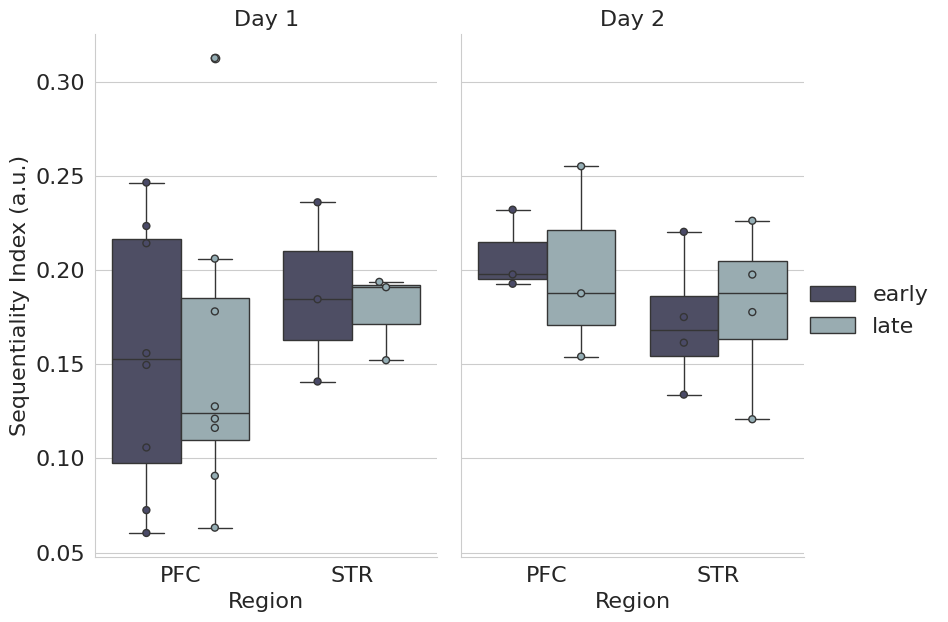

In [156]:
sqi_comparison_day_region_moment = boxplot_comparison(both_days_both_regions_df,variable_of_interest='sqi',variable_title = 'Sequentiality Index (a.u.)',color_palette='bone')
plt.savefig('./results/sqi_comparison_region_day_sessionmoment.svg')
plt.savefig('./results/sqi_comparison_region_day_sessionmoment.png')

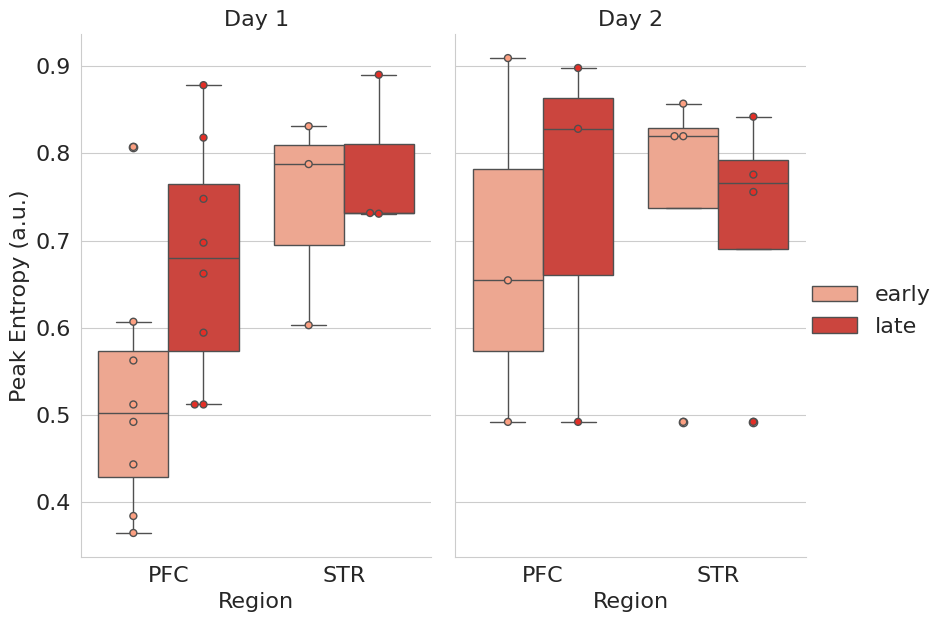

In [157]:
pe_comparison_day_region_moment = boxplot_comparison(both_days_both_regions_df,variable_of_interest='pe',variable_title = 'Peak Entropy (a.u.)',color_palette='Reds')
plt.savefig('./results/pe_comparison_region_day_sessionmoment.svg')
plt.savefig('./results/pe_comparison_region_day_sessionmoment.png')

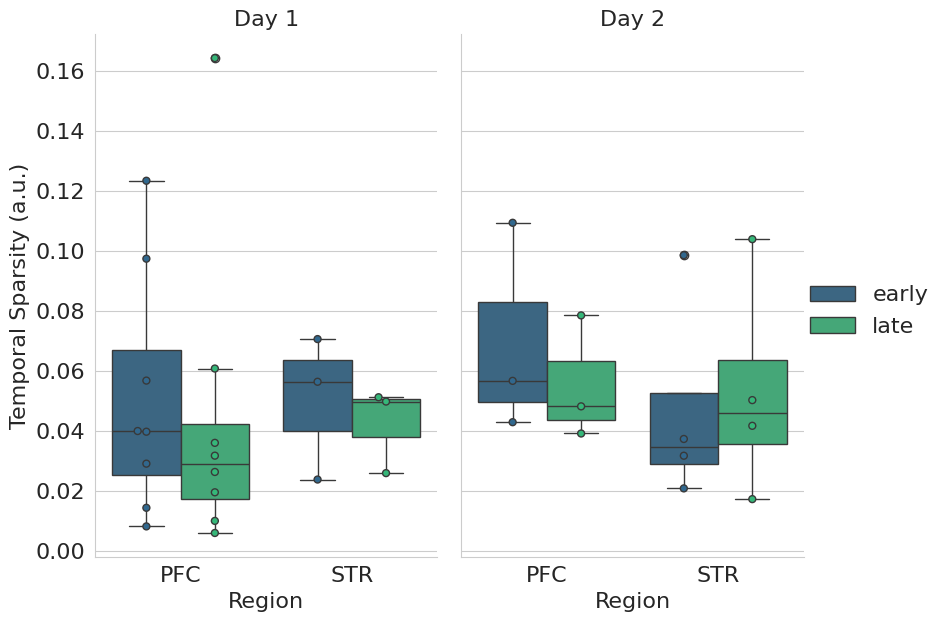

In [158]:
ts_comparison_day_region_moment = boxplot_comparison(both_days_both_regions_df,variable_of_interest='ts',variable_title = 'Temporal Sparsity (a.u.)',color_palette='viridis')
plt.savefig('./results/ts_comparison_region_day_sessionmoment.svg')
plt.savefig('./results/ts_comparison_region_day_sessionmoment.png')

# Statistical comparison of SqI, PE and TS

In [48]:
df = both_days_both_regions_df.copy()

### PFC/STR (one day and session part at a time)

In [63]:
def filter_animals_by_session_and_day(df, day, session_part):
    """
    Filter the DataFrame based on the specified region, session_part,
    and ensure that the animal_id exists in both day 1 and day 2.

    Parameters:
    - df: pandas DataFrame to filter.
    - day: The day to filter by.
    - session_part: The part of the session to filter by.

    Returns:
    - A filtered DataFrame based on the specified criteria.
    """

    # Filter the dataframe based on session_part and region
    filtered_df = df[(df['session_part'] == session_part) & (df['day'] == day)]

    # Identify animal_id that exists in both day 1 and day 2
    animals_in_both_regions = filtered_df[filtered_df['region'].isin(['PFC', 'STR'])]['animal_id'].value_counts()
    animals_in_both_regions = animals_in_both_regions[animals_in_both_regions >= 2].index.tolist()

    # Select entries with those animal_ids and ensure they are present on both days
    final_df = filtered_df[filtered_df['animal_id'].isin(animals_in_both_regions)]

    # Check to ensure only animals present on both days are included
    final_animals_region_check = final_df.groupby('animal_id')['region'].nunique()
    final_animals_with_both_regions = final_animals_region_check[final_animals_region_check == 2].index.tolist()
    final_selection = final_df[final_df['animal_id'].isin(final_animals_with_both_regions)]

    return final_selection

In [92]:
regions_comparison = []

for target_variable in ['SqI','PE','TS']:
  for target_day in df.day.unique():
    for target_session_part in df.session_part.unique():
      current = filter_animals_by_session_and_day(df, target_day, target_session_part)

      PFC = current.query('region == "PFC"')[target_variable.lower()].values
      STR = current.query('region == "STR"')[target_variable.lower()].values

      label = f'{target_variable}, Day {target_day}, {target_session_part.title()}'
      t,p = stats.ttest_rel(PFC, STR)
      regions_comparison.append({'Variable':target_variable,'Day':target_day,'Session part':target_session_part,'t_score':t,'p_value':p})

regions_comparison = pd.DataFrame(regions_comparison)

In [94]:
regions_comparison

,Variable,Day,Session part,t_score,p_value
0,SqI,1,early,0.039453,0.972113
1,SqI,1,late,0.516628,0.656868
2,SqI,2,early,2.082978,0.172665
3,SqI,2,late,2.446931,0.134201
4,PE,1,early,-2.217375,0.156883
5,PE,1,late,-2.038850,0.178318
6,PE,2,early,-1.116629,0.380306
7,PE,2,late,-0.342126,0.764863
8,TS,1,early,0.809328,0.503303
9,TS,1,late,0.879320,0.471973


### Early/late comparison in the same day (one region at a time)

In [99]:
session_part_comparison = []

for target_variable in ['SqI','PE','TS']:
  for target_region in df.region.unique():
    for target_day in df.day.unique():
      current = df.query(f'day == {target_day} and region == "{target_region}"')

      early = current.query('session_part == "early"')[target_variable.lower()].values
      late = current.query('session_part == "late"')[target_variable.lower()].values

      #print(f'{target_variable}, {target_region}, {target_day}')
      t,p = stats.ttest_rel(early, late)
      session_part_comparison.append({'Variable':target_variable,'Region':target_region,'Day':target_day,'t_score':t,'p_value':p})

session_part_comparison = pd.DataFrame(session_part_comparison)

In [100]:
session_part_comparison

,Variable,Region,Day,t_score,p_value
0,SqI,PFC,1,0.079956,0.938510
1,SqI,PFC,2,0.210847,0.852538
2,SqI,STR,1,0.478430,0.679540
3,SqI,STR,2,-1.013786,0.385341
4,PE,PFC,1,-3.262619,0.013814
5,PE,PFC,2,-0.903555,0.461598
6,PE,STR,1,-0.812382,0.501893
7,PE,STR,2,2.140801,0.121761
8,TS,PFC,1,0.578704,0.580923
9,TS,PFC,2,0.585939,0.617232


#### Plotting specifically the only significant difference

In [144]:
print({'pre':pre, 'post':post})

{'pre': array([0.44315549, 0.3644427 , 0.60686383, 0.56238066, 0.38393704,
       0.80743493, 0.49193292, 0.51191605]), 'post': array([0.6621347 , 0.81816006, 0.74789094, 0.69760862, 0.51191605,
       0.87836825, 0.59431613, 0.51191605])}


/content/drive/MyDrive/backup-mac/ufabc/entire-backup/sqi/corrected_2023/results/pe_PFC_day1.svg
TtestResult(statistic=-3.2626192316676557, pvalue=0.013814337753380458, df=7)


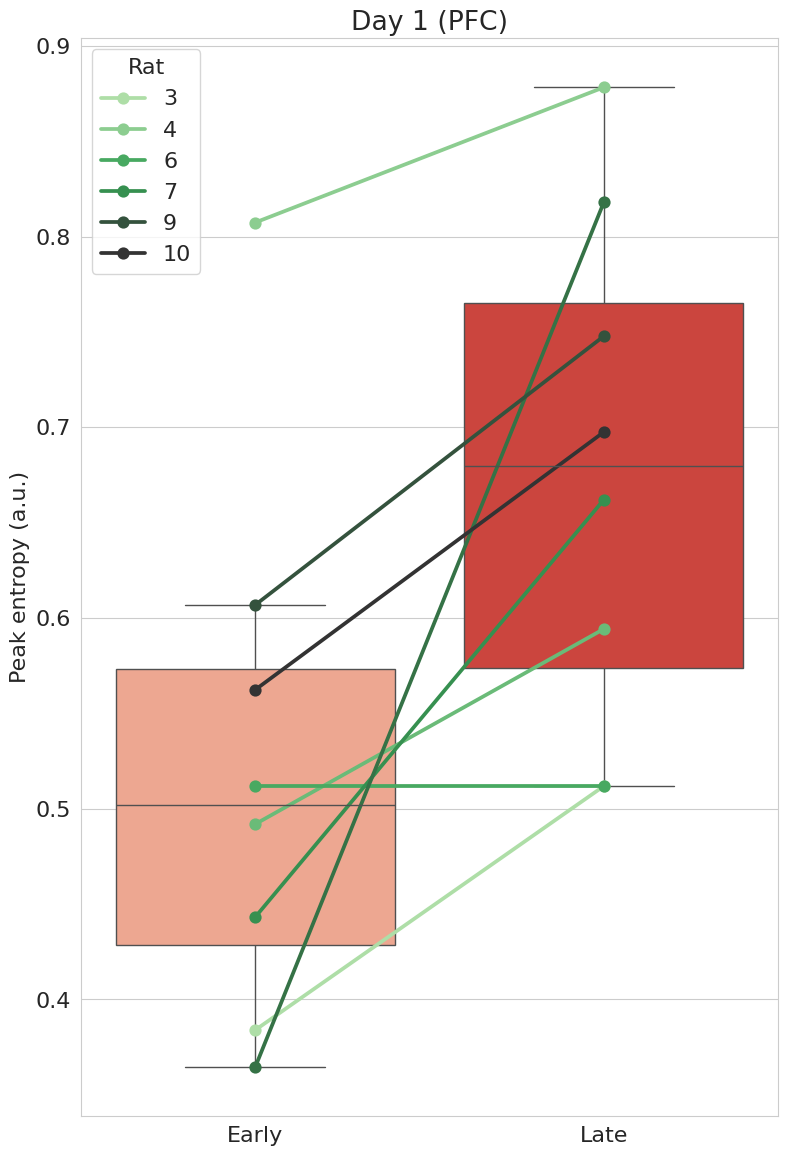

In [153]:
saving_path = os.getcwd() + '/results'
variable_of_interest = ['pe','Peak entropy','viridis']

#plots:
#PFC day 1 (early, late)
current = both_days_both_regions_df.query('region == "PFC" and day == 1')

plt.figure(figsize=(9,14))
sns.set_style("whitegrid")
ax = sns.boxplot(data = current,x=current['session_part'].values,y=current[variable_of_interest[0]].values,hue = 'session_part',palette = 'Reds')
sns.pointplot(data = current,x=current['session_part'].values,y=current[variable_of_interest[0]].values,hue=current['animal_id'].values,palette = 'Greens_d')
plt.title('Day 1 (PFC)')
plt.xticks(plt.xticks()[0],['Early','Late'])
plt.ylabel(f'{variable_of_interest[1]} (a.u.)')
plt.legend(title='Rat')
figure_path = saving_path+'/'+variable_of_interest[0]+'_PFC_day1.svg'
print(figure_path)
plt.savefig(figure_path)

import scipy.stats as stats

pre = current.query('session_part == "early"')[variable_of_interest[0]].values
post = current.query('session_part == "late"')[variable_of_interest[0]].values

# Performing the paired sample t-test
print(stats.ttest_rel(pre, post))

### Day 1/Day 2 comparison (one region at a time)

In [30]:
def filter_animals_by_session_and_region(df, region, session_part):
    """
    Filter the DataFrame based on the specified region, session_part,
    and ensure that the animal_id exists in both day 1 and day 2.

    Parameters:
    - df: pandas DataFrame to filter.
    - region: The region to filter by.
    - session_part: The part of the session to filter by.

    Returns:
    - A filtered DataFrame based on the specified criteria.
    """

    # Filter the dataframe based on session_part and region
    filtered_df = df[(df['session_part'] == session_part) & (df['region'] == region)]

    # Identify animal_id that exists in both day 1 and day 2
    animals_in_both_days = filtered_df[filtered_df['day'].isin([1, 2])]['animal_id'].value_counts()
    animals_in_both_days = animals_in_both_days[animals_in_both_days >= 2].index.tolist()

    # Select entries with those animal_ids and ensure they are present on both days
    final_df = filtered_df[filtered_df['animal_id'].isin(animals_in_both_days)]

    # Check to ensure only animals present on both days are included
    final_animals_day_check = final_df.groupby('animal_id')['day'].nunique()
    final_animals_with_both_days = final_animals_day_check[final_animals_day_check == 2].index.tolist()
    final_selection = final_df[final_df['animal_id'].isin(final_animals_with_both_days)]

    return final_selection

In [95]:
days_comparison = []

for target_variable in ['SqI','PE','TS']:
  for target_region in df.region.unique():
    for target_session_part in df.session_part.unique():
      current = filter_animals_by_session_and_region(df, target_region, target_session_part)

      day1 = current.query('day == 1')[target_variable.lower()].values
      day2 = current.query('day == 2')[target_variable.lower()].values

      label = f'{target_variable}, {target_region}, {target_session_part.title()}'
      t,p = stats.ttest_rel(day1, day2)
      days_comparison.append({'Variable':target_variable,'Region':target_region,'Session part':target_session_part,'t_score':t,'p_value':p})

days_comparison = pd.DataFrame(days_comparison)

In [96]:
days_comparison

,Variable,Region,Session part,t_score,p_value
0,SqI,PFC,early,-0.546446,0.639575
1,SqI,PFC,late,0.085904,0.939368
2,SqI,STR,early,0.820426,0.498199
3,SqI,STR,late,0.449099,0.697334
4,PE,PFC,early,-1.574450,0.256050
5,PE,PFC,late,-0.626439,0.594996
6,PE,STR,early,-1.370195,0.304159
7,PE,STR,late,-0.095051,0.932940
8,TS,PFC,early,0.006741,0.995233
9,TS,PFC,late,0.453564,0.694604


# Neural activity visualization (raster plots and heatmaps)

In [9]:
#select group/region/day/eligible trials (duration criteria [1.5,3.5])/eligible spikes (time-in-trial criteria, [-0.5,1.5])
filter_trials_between = [1.5,3.5]


data_subset = data.loc[(data['group']== 2) & (data['day']== 1) & (data['region']== 'STR')
                    & (data['duration']>=filter_trials_between[0]) & (data['duration']<=filter_trials_between[1])
                    & (data['time']>=-0.5) & (data['time']<=filter_trials_between[0])]


separated_rats = separate_rats(data_subset,check_num_neurons=True,min_num_neurons = 4)

least_amount_of_trials = min([animal.trial.nunique() for animal in separated_rats])
trials_in_thirds = int(least_amount_of_trials/3)

for animal in separated_rats:
  animal_pruned = least_amount_spikes(animal,num_spikes_threshold=5)
  current_num_neurons = animal_pruned.neuron.nunique()

  print(animal_pruned.trial.nunique())

  binned_spikes = time_binning(animal_pruned)
  convolved_spikes = convolve_raster(binned_spikes)

  norm_first_mean_convolved = normalise_data(np.expand_dims(np.mean(convolved_spikes[0:trials_in_thirds,:,:],axis=0),axis=0))
  norm_last_mean_convolved = normalise_data(np.expand_dims(np.mean(convolved_spikes[-trials_in_thirds:,:,:],axis=0),axis=0))
  break

262
(262, 12, 1500)


In [10]:
def plot_spiketrain_raster(activity_matrix,trial=0):
  if trial < 0:
    trial_id = np.shape(activity_matrix)[0] + trial
  else:
    trial_id = trial

  num_neurons,trial_duration = np.shape(activity_matrix[trial,:,:])

  plt.figure(figsize=(5,5))
#  plt.title(f'Raster plot for spikes of {num_neurons} neurons (trial {trial_id+1})')
  plt.xlabel('Trial duration (ms)')
  plt.yticks(range(0,num_neurons),labels=range(1,num_neurons+1))
  plt.ylabel('Neuron (#)')
  #an eventplot does not work with a binary array, so we pass the indexes at which an event (spike) happens instead
  plt.eventplot([np.where(activity_matrix[trial,current_neuron,:] == 1)[0] for current_neuron in range(num_neurons)],color='blue');

def plot_activity_heatmap(activity_matrix,order_by_peak_latency=False,norm_each_neuron=False,other_ordering=None):
  #activity_matrix: 2D matrix (neurons, timebins)

  fig, ax = plt.subplots(figsize=(9, 9))

  num_neurons,timebins = np.shape(activity_matrix)

  if norm_each_neuron:
    for i in range(np.shape(activity_matrix)[0]):
      #find the maximum for that neuron over all time bins and divide every bin by this value
      activity_matrix[i,:] = activity_matrix[i,:]/activity_matrix.max(axis=1)[i]

  if order_by_peak_latency:
    rates = ax.matshow(activity_matrix[peak_latency_ordering(activity_matrix),:],aspect="auto",origin='lower')
  elif other_ordering:
    rates = ax.matshow(activity_matrix[other_ordering,:],aspect="auto",origin='lower')
  else:
    rates = ax.matshow(activity_matrix[:,:],aspect="auto",origin='lower')

  ax.xaxis.tick_bottom()
  ax.xaxis.set_label_position('bottom')
  ax.set_xlabel('Time (ms)')
  ax.set_xticks(range(0,15,1),labels=range(100,1600,100))
  ax.set_ylabel('Neuron (#)')

  fig.colorbar(rates, ax=ax, label='Normalised firing rate (a.u.)')

In [30]:
def peak_latency_ordering(activity_matrix):
  peak_times = np.argmax(activity_matrix,axis=1) #the timebin with each neuron's maximum
  new_neuron_ordering = np.argsort(peak_times)

  return np.array(new_neuron_ordering)

def plot_trial_firing_rates(normalized_firing_rates_matrix,trial_index=0,show_peak=True,order_latencies=True,show_entropic_bins=True,
                            num_entropic_bins=15,lower_time_resolution=False,normalize_each_neuron=False,specific_neuron_ordering=None,title_complement=None):
  #normalized_firing_rates_matrix: 3d (trials, neurons, timebins)

  #just in case there are NaN values in the matrix
  normalized_firing_rates_matrix = np.nan_to_num(normalized_firing_rates_matrix,0)

  fig, ax = plt.subplots(figsize=(9, 8))
  num_trials,num_neurons,timebins = np.shape(normalized_firing_rates_matrix)

  if lower_time_resolution:
    low_res_activity = np.zeros([num_neurons,15])
    ax.set_xticks(range(0,16,1),labels=range(0,1600,100))

    for i in range(15):
      low_res_activity[:,i] = np.mean(normalized_firing_rates_matrix[trial_index,:,i*100:(i+1)*100],axis=1)

    normalized_firing_rates_matrix = np.expand_dims(low_res_activity,axis=0)

  if show_entropic_bins:
    entropic_binsize = timebins/(num_entropic_bins - 1)
    entropic_bin_positions = np.arange(start=0-entropic_binsize/2,stop=timebins+entropic_binsize/2,step=entropic_binsize)
    entropic_bin_positions = entropic_bin_positions[(entropic_bin_positions >= 0) & (entropic_bin_positions <= timebins)]
    for bin_position in entropic_bin_positions:
      ax.vlines(bin_position,ymin=0-.5,ymax=num_neurons - .5,color='white',linestyle='dotted',linewidth=1.1)

  if order_latencies:
    new_neuron_ordering = peak_latency_ordering(normalized_firing_rates_matrix[trial_index,:,:])
    normalized_firing_rates_matrix = normalized_firing_rates_matrix[:,new_neuron_ordering,:]

  if show_peak:
    peaktimes = np.argmax(normalized_firing_rates_matrix[trial_index],axis=1)

    for neuron in range(num_neurons):
      if peaktimes[neuron] < 5:
        if lower_time_resolution == False:
          peaktimes[neuron] = 6 #displace it a little so it'll be visible in the plot
      ax.vlines(peaktimes[neuron],ymin=neuron - .5,ymax=neuron + .5,color='red',linewidth=1.5)

  if normalize_each_neuron:
    for i in range(num_neurons):
      normalized_firing_rates_matrix[trial_index,i,:] = normalized_firing_rates_matrix[trial_index,i,:]/max(normalized_firing_rates_matrix[trial_index,i,:])
    #just in case there are NaN values in the matrix
    normalized_firing_rates_matrix = np.nan_to_num(normalized_firing_rates_matrix,0)

  if specific_neuron_ordering is not None:
    rates = ax.matshow(normalized_firing_rates_matrix[trial_index,specific_neuron_ordering,:],aspect="auto",origin='lower',vmin=0,vmax=1,cmap='viridis')
  else:
    rates = ax.matshow(normalized_firing_rates_matrix[trial_index,:,:],aspect="auto",origin='lower',vmin=0,vmax=1,cmap='viridis')

  ax.xaxis.tick_bottom()
  ax.xaxis.set_label_position('bottom')
  if lower_time_resolution:
    xticks = np.arange(0, 15, 3)
    xlabels = np.arange(100,1600,300)
    ax.set_xticks(xticks, labels=xlabels)

  ax.set_xlabel('Time (ms)')
  ax.set_ylabel('Neuron (#)')

  fig.colorbar(rates, ax=ax, label='Normalised firing rate (a.u.)')
  if title_complement:
    plt.title(f'Normalised firing activity of each neuron \n{title_complement}')
  else:
    plt.title(f'Normalised firing activity of each neuron')
  plt.tight_layout()

603
(603, 17, 1500)
first N trials (rat [7]), lowered resolution
last N trials (rat [7]), lowered resolution
first N trials (rat [7]), full resolution
last N trials (rat [7]), full resolution


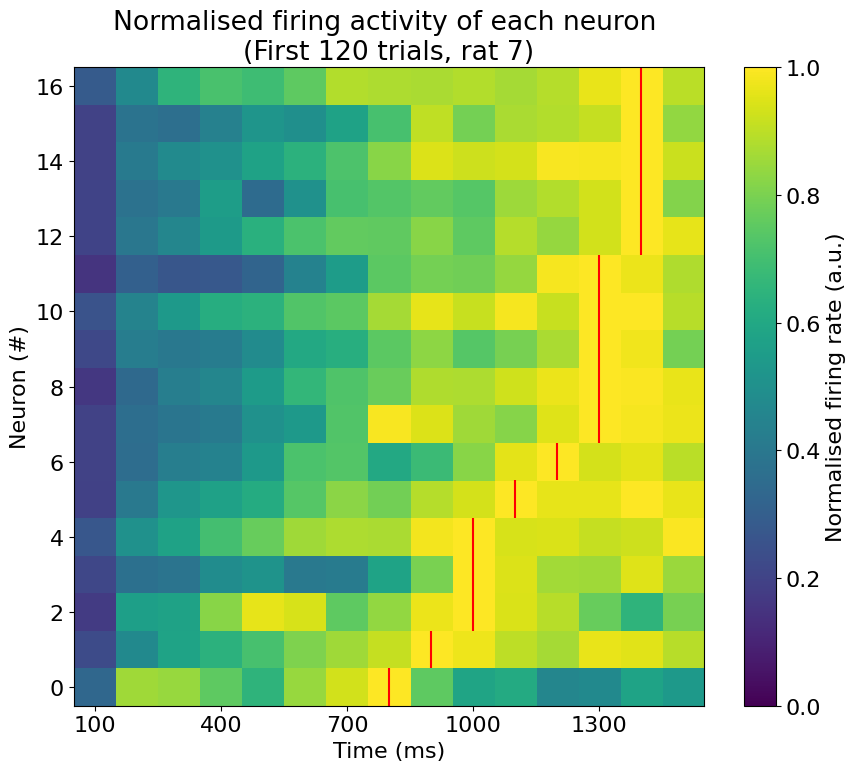

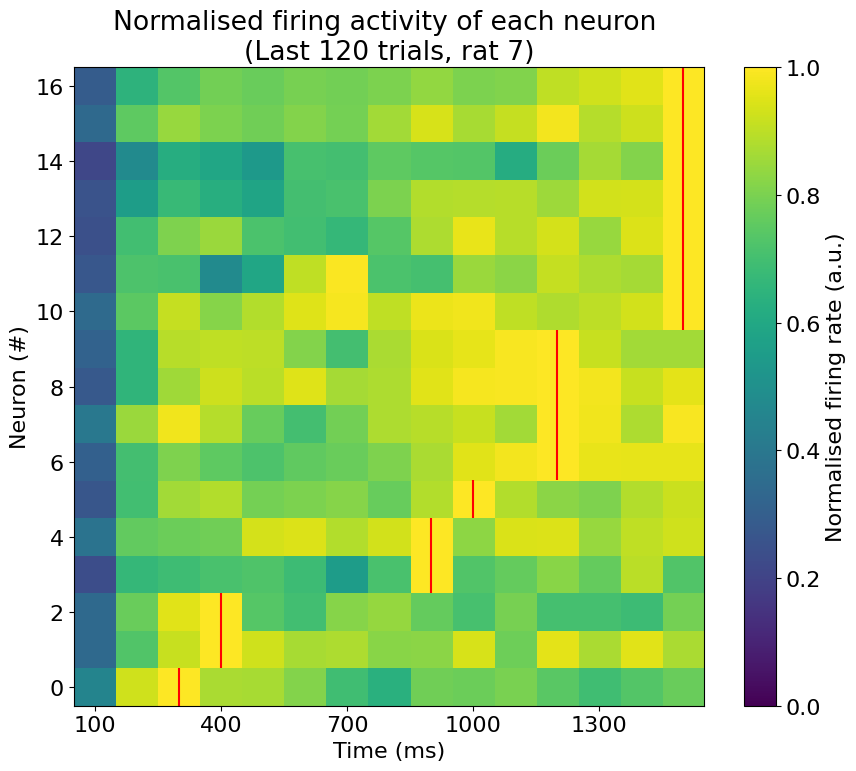

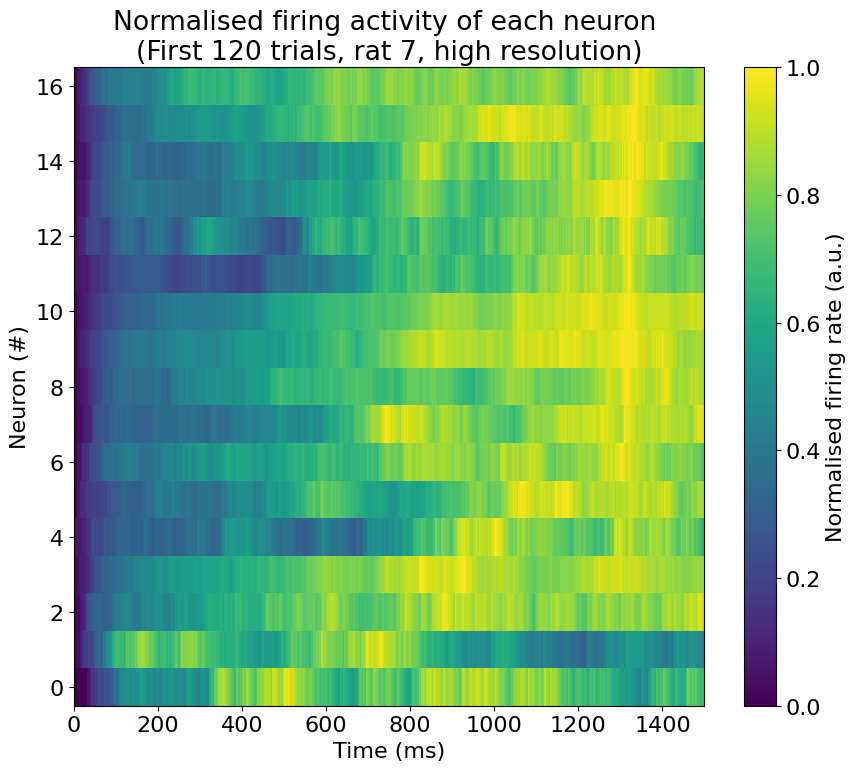

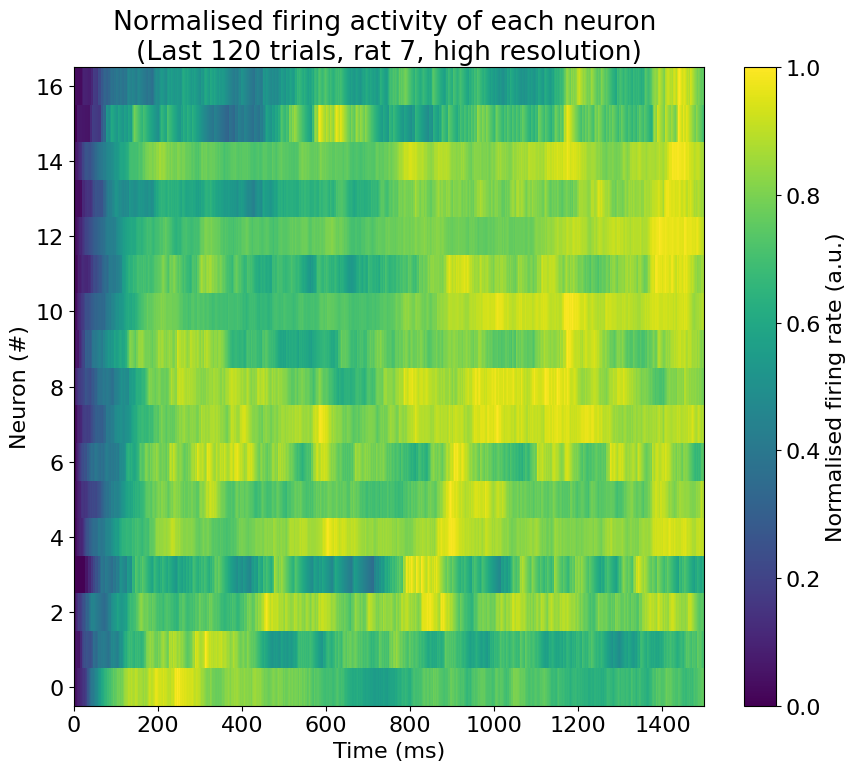

In [37]:
#select group/region/day/eligible trials (duration criteria [1.5,3.5])/eligible spikes (time-in-trial criteria, [-0.5,1.5])
filter_trials_between = [1.5,3.5]


data_subset = data.loc[(data['group']== 1) & (data['day']== 1) & (data['region']== 'PFC')
                    & (data['duration']>=filter_trials_between[0]) & (data['duration']<=filter_trials_between[1])
                    & (data['time']>=-0.5) & (data['time']<=filter_trials_between[0])]


separated_rats = separate_rats(data_subset,check_num_neurons=True,min_num_neurons = 4)

least_amount_of_trials = min([animal.trial.nunique() for animal in separated_rats])
trials_in_thirds = int(least_amount_of_trials/3)

for animal in separated_rats:
  animal_pruned = least_amount_spikes(animal,num_spikes_threshold=5)
  current_num_neurons = animal_pruned.neuron.nunique()

  print(animal_pruned.trial.nunique())

  binned_spikes = time_binning(animal_pruned)
  convolved_spikes = convolve_raster(binned_spikes)

  norm_first_mean_convolved = normalise_data(np.expand_dims(np.mean(convolved_spikes[0:trials_in_thirds,:,:],axis=0),axis=0))
  norm_last_mean_convolved = normalise_data(np.expand_dims(np.mean(convolved_spikes[-trials_in_thirds:,:,:],axis=0),axis=0))

  print(f'first N trials (rat {animal.rat.unique()}), lowered resolution')
  plot_trial_firing_rates(norm_first_mean_convolved,trial_index=0,show_peak=True,show_entropic_bins=True,num_entropic_bins=15,
                        lower_time_resolution=True,order_latencies=True,normalize_each_neuron=True,title_complement=f'(First {trials_in_thirds} trials, rat {animal.rat.unique()[0]})')
  print(f'last N trials (rat {animal.rat.unique()}), lowered resolution')
  plot_trial_firing_rates(norm_last_mean_convolved,trial_index=0,show_peak=True,show_entropic_bins=True,num_entropic_bins=15,
                        lower_time_resolution=True,order_latencies=True,normalize_each_neuron=True,title_complement=f'(Last {trials_in_thirds} trials, rat {animal.rat.unique()[0]})')

  print(f'first N trials (rat {animal.rat.unique()}), full resolution')
  plot_trial_firing_rates(norm_first_mean_convolved,trial_index=0,show_peak=False,show_entropic_bins=False,num_entropic_bins=15,
                        lower_time_resolution=False,order_latencies=True,normalize_each_neuron=True,title_complement=f'(First {trials_in_thirds} trials, rat {animal.rat.unique()[0]}, high resolution)')

  print(f'last N trials (rat {animal.rat.unique()}), full resolution')
  plot_trial_firing_rates(norm_last_mean_convolved,trial_index=0,show_peak=False,show_entropic_bins=False,num_entropic_bins=15,
                        lower_time_resolution=False,order_latencies=True,normalize_each_neuron=True,title_complement=f'(Last {trials_in_thirds} trials, rat {animal.rat.unique()[0]}, high resolution)')

  break
#  plot_trial_firing_rates(norm_last_mean_convolved,trial_index=0,show_peak=True,show_entropic_bins=True,num_entropic_bins=15,
#                        lower_time_resolution=True,order_latencies=True,normalize_each_neuron=True,title_complement='(Late trials)')

# Simulated spike trains

In [38]:
def random_spike_trains(num_trials,num_neurons,trial_duration,total_num_spikes,same_spike_count_per_neuron=True):
  spikes_matrix = np.zeros([num_trials,num_neurons,trial_duration])

  for trial in range(num_trials):
    for neuron in range(num_neurons):

      if same_spike_count_per_neuron:
        #this assumes each neuron has the same number of spikes throughout the trial
        spikes_per_neuron = int(total_num_spikes/num_neurons)
      else:
        #select a random integer from [0,num_total_spikes/num_neurons] to stand for the spike count of this given neuron at the present trial
        spikes_per_neuron = np.random.randint(low = 0,high = int(total_num_spikes/num_neurons))

      #fill the current neuron's spike train (that is: in the {current trial, neuron,:} of spikes_matrix) with ones at random N indexes selected
      spikes_matrix[trial,neuron,np.random.choice(range(trial_duration),size = spikes_per_neuron)] = 1

  return spikes_matrix


def dithered_spike_trains(num_trials,num_neurons,trial_duration,total_num_spikes,same_spike_count_per_neuron=True,peak_width=300):
  spikes_matrix = np.zeros([num_trials,num_neurons,trial_duration])

  peak_positions = np.linspace(start=0,stop=trial_duration,num=num_neurons,dtype=int)

  for trial in range(num_trials):
    for neuron in range(num_neurons):
      #randomly determine whether this spike train will be dithered or not, and towards which side
      dither = random.randint(-5,+5) #0 is no dither, +values = a displacement towards later in trial, -values = a displacement to earlier in trial

      if same_spike_count_per_neuron:
        #this assumes each neuron has the same number of spikes throughout the trial
        spikes_per_neuron = int(total_num_spikes/num_neurons)
      else:
        #select a random integer from [0,num_total_spikes/num_neurons] to stand for the spike count of this given neuron at the present trial
        spikes_per_neuron = np.random.randint(low = 0,high = int(total_num_spikes/num_neurons))

      #position the current neuron's peak
      peak_location = peak_positions[neuron]+dither*(trial_duration/num_neurons)

      #create a vector with probabilities for the current neuron to spike in each time bin
      time_probs = [(np.exp((-1/2)*((index-peak_location)/peak_width)**2)) for index in range(trial_duration)]

      #fill the current neuron's spike train (that is: in the {current trial, neuron,:} of spikes_matrix) with ones at random N indexes selected with this probability distribution around the peak
      spikes_matrix[trial,neuron,np.random.choice(range(trial_duration),size = spikes_per_neuron,p = time_probs/np.sum(time_probs))] = 1

  return spikes_matrix

def chained_spike_trains(num_trials,num_neurons,trial_duration,total_num_spikes,same_spike_count_per_neuron=True,peak_width=300):
  spikes_matrix = np.zeros([num_trials,num_neurons,trial_duration])

  peak_positions = np.linspace(start=0,stop=trial_duration,num=num_neurons,dtype=int)

  for trial in range(num_trials):
    for neuron in range(num_neurons):
      if same_spike_count_per_neuron:
        #this assumes each neuron has the same number of spikes throughout the trial
        spikes_per_neuron = int(total_num_spikes/num_neurons)
      else:
        #select a random integer from [0,num_total_spikes/num_neurons] to stand for the spike count of this given neuron at the present trial
        spikes_per_neuron = np.random.randint(low = 0,high = int(total_num_spikes/num_neurons))

      #position the current neuron's peak
      peak_location = peak_positions[neuron]

      #create a vector with probabilities for the current neuron to spike in each time bin
      time_probs = [(np.exp((-1/2)*((index-peak_location)/peak_width)**2)) for index in range(trial_duration)]

      #fill the current neuron's spike train (that is: in the {current trial, neuron,:} of spikes_matrix) with ones at random N indexes selected with this probability distribution around the peak
      spikes_matrix[trial,neuron,np.random.choice(range(trial_duration),size = spikes_per_neuron,p = time_probs/np.sum(time_probs))] = 1

  return spikes_matrix

In [39]:
num_neurons = 25
num_trials = 1
total_num_spikes = 200
trial_duration = 1500

random_spikes_matrix = random_spike_trains(num_trials=num_trials,num_neurons=num_neurons,trial_duration=trial_duration,total_num_spikes=total_num_spikes,same_spike_count_per_neuron=False)
dithered_spikes_matrix = dithered_spike_trains(num_trials=num_trials,num_neurons=num_neurons,trial_duration=trial_duration,
                                               total_num_spikes=total_num_spikes,same_spike_count_per_neuron=False,peak_width=50)
chained_spikes_matrix = chained_spike_trains(num_trials=num_trials,num_neurons=num_neurons,trial_duration=trial_duration,
                                             total_num_spikes=total_num_spikes,same_spike_count_per_neuron=False,peak_width=50)

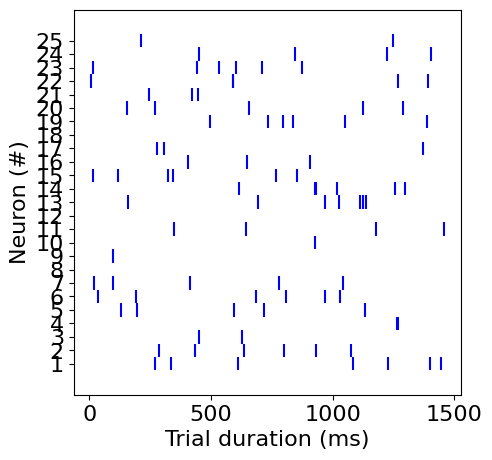

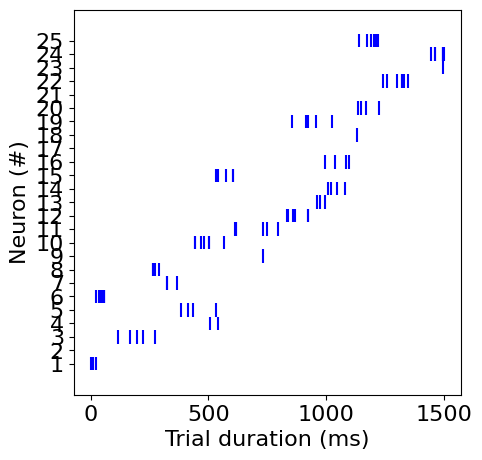

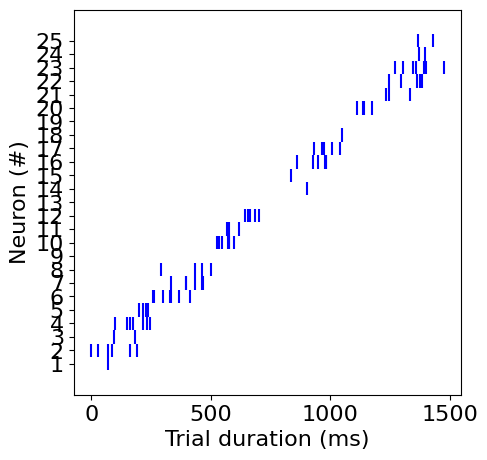

In [40]:
sample_trial = np.random.randint(low = 0, high = num_trials)

plot_spiketrain_raster(random_spikes_matrix,trial=sample_trial)
plot_spiketrain_raster(dithered_spikes_matrix,trial=sample_trial)
plot_spiketrain_raster(chained_spikes_matrix,trial=sample_trial)

# Kernel and convolution demonstration

In [41]:
x = np.linspace(0,750,750)

kernel = np.exp(-x/100)
kernel = np.pad(kernel,(750,0),'constant')

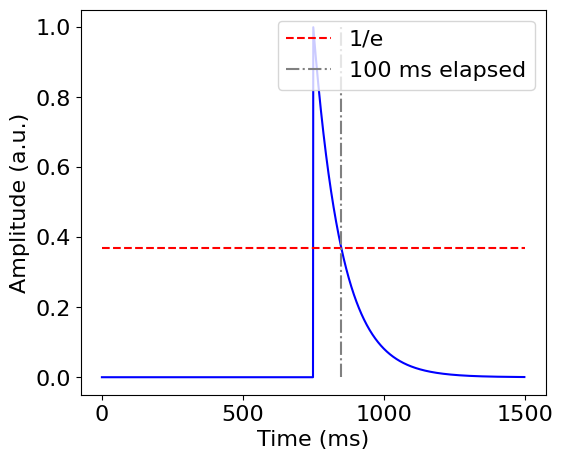

In [42]:
plt.figure(figsize=(6,5))

plt.plot(kernel,color='blue')
plt.hlines(1/np.e,0,1500,color='red',linestyle='--',label='1/e')
plt.vlines(850,0,1,color='grey',linestyle='-.',label='100 ms elapsed')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (a.u.)')
plt.legend()

## convolving a simulated spike train

(10, 15, 1500)


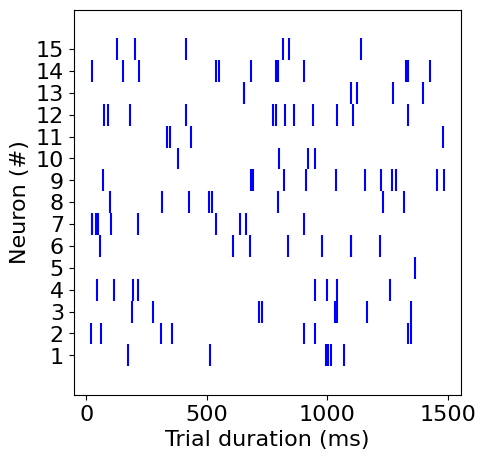

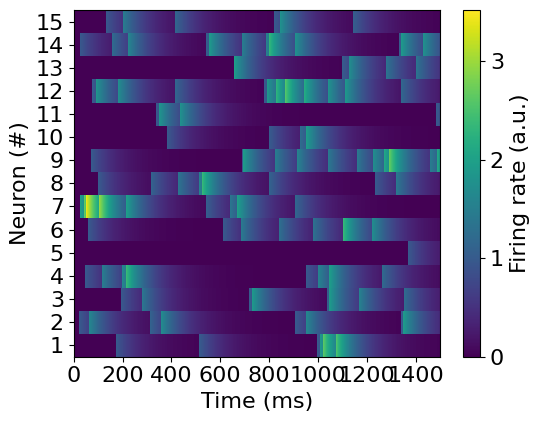

In [43]:
random_spikes_matrix = random_spike_trains(num_trials=10,num_neurons=15,trial_duration=1500,total_num_spikes=200,same_spike_count_per_neuron=False)

sample_trial = np.random.randint(low = 0, high = 10)

plot_spiketrain_raster(random_spikes_matrix,trial=sample_trial)

convolved_simulated_test = convolve_raster(random_spikes_matrix)

fig, ax = plt.subplots(figsize=(5.7, 4.5))
rates = ax.matshow(convolved_simulated_test[sample_trial],aspect='auto',origin='lower')
ax.xaxis.tick_bottom()
ax.set_yticks(range(0,15),labels=range(1,16,1))
ax.xaxis.set_label_position('bottom')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Neuron (#)')
fig.colorbar(rates, ax=ax, label='Firing rate (a.u.)')
plt.tight_layout()
plt.show()

# Neuron's preferred peak time change over session

In [44]:
#select group/region/day/eligible trials (duration criteria [1.5,3.5])/eligible spikes (time-in-trial criteria, [-0.5,1.5])
filter_trials_between = [1.5,3.5]


data_subset = data.loc[(data['group']== 2) & (data['day']== 1) & (data['region']== 'STR')
                    & (data['duration']>=filter_trials_between[0]) & (data['duration']<=filter_trials_between[1])
                    & (data['time']>=-0.5) & (data['time']<=filter_trials_between[0])]


separated_rats = separate_rats(data_subset,check_num_neurons=True,min_num_neurons = 4)

least_amount_of_trials = min([animal.trial.nunique() for animal in separated_rats])
trials_in_thirds = int(least_amount_of_trials/3)

for animal in separated_rats:
  animal_pruned = least_amount_spikes(animal,num_spikes_threshold=5)
  current_num_neurons = animal_pruned.neuron.nunique()

  print(animal_pruned.trial.nunique())

  binned_spikes = time_binning(animal_pruned)
  convolved_spikes = convolve_raster(binned_spikes)

  norm_first_mean_convolved = normalise_data(np.expand_dims(np.mean(convolved_spikes[0:trials_in_thirds,:,:],axis=0),axis=0))
  norm_last_mean_convolved = normalise_data(np.expand_dims(np.mean(convolved_spikes[-trials_in_thirds:,:,:],axis=0),axis=0))
  break

262
(262, 12, 1500)


In [63]:
rat = animal_pruned.rat.unique()[0]
title_complement_baseline = f'(Rat {rat}, '

First third of trials, no peak latency ordering


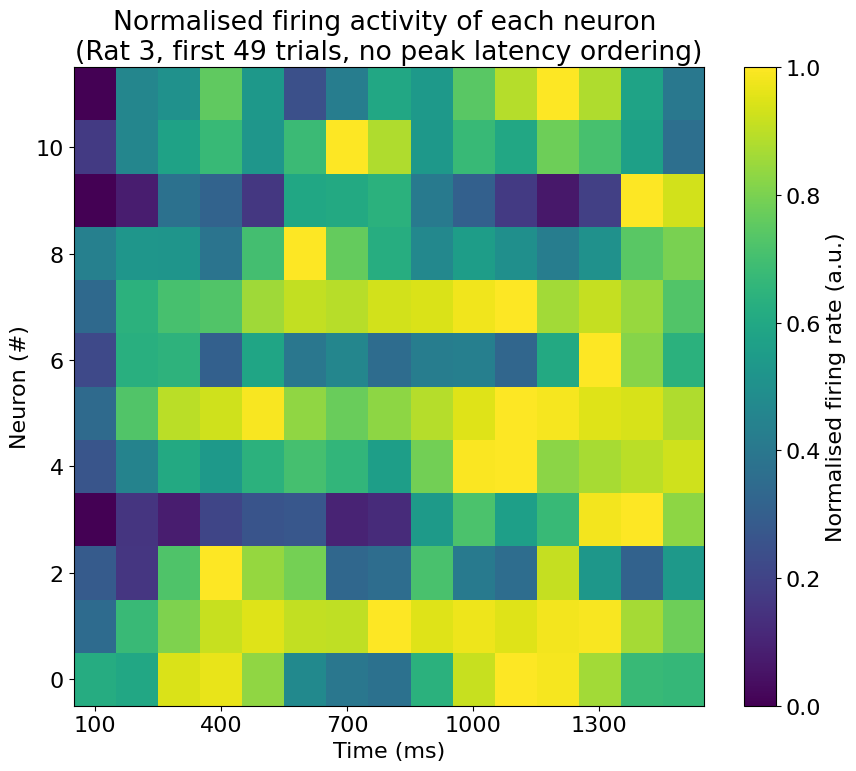

In [66]:
plot_identification = f'first {trials_in_thirds} trials, no peak latency ordering)' #trial segment, ordering
print('First third of trials, no peak latency ordering')
plot_trial_firing_rates(norm_first_mean_convolved,trial_index=0,show_peak=False,order_latencies=False,show_entropic_bins=False,
                            num_entropic_bins=15,lower_time_resolution=True,normalize_each_neuron=True,title_complement=title_complement_baseline+plot_identification)

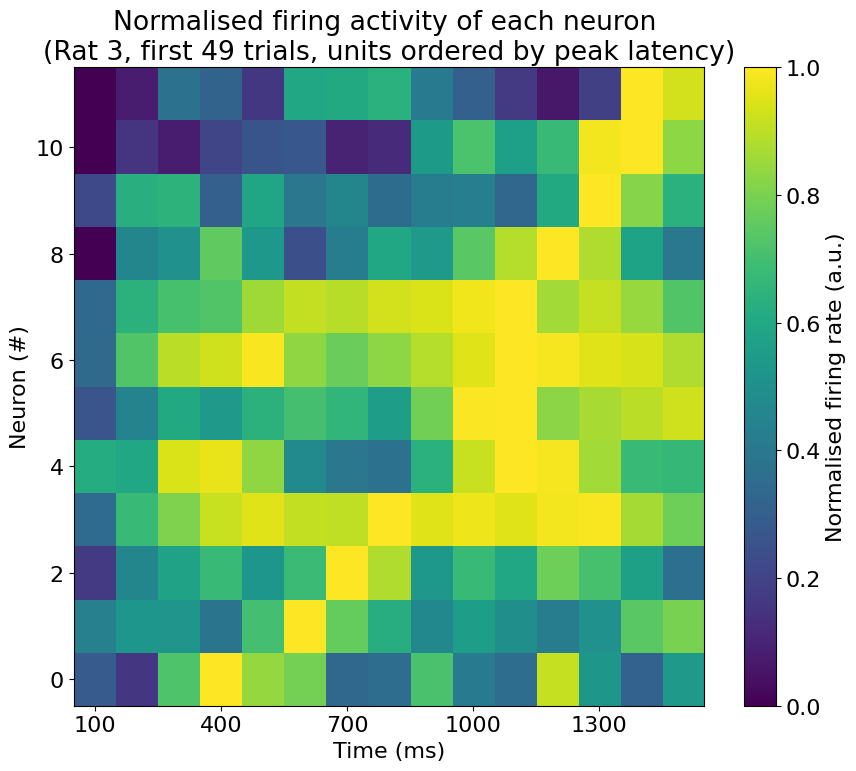

In [67]:
plot_identification = f'first {trials_in_thirds} trials, units ordered by peak latency)' #trial segment, ordering
plot_trial_firing_rates(norm_first_mean_convolved,trial_index=0,show_peak=False,order_latencies=True,show_entropic_bins=False,
                            num_entropic_bins=15,lower_time_resolution=True,normalize_each_neuron=True,title_complement=title_complement_baseline+plot_identification)

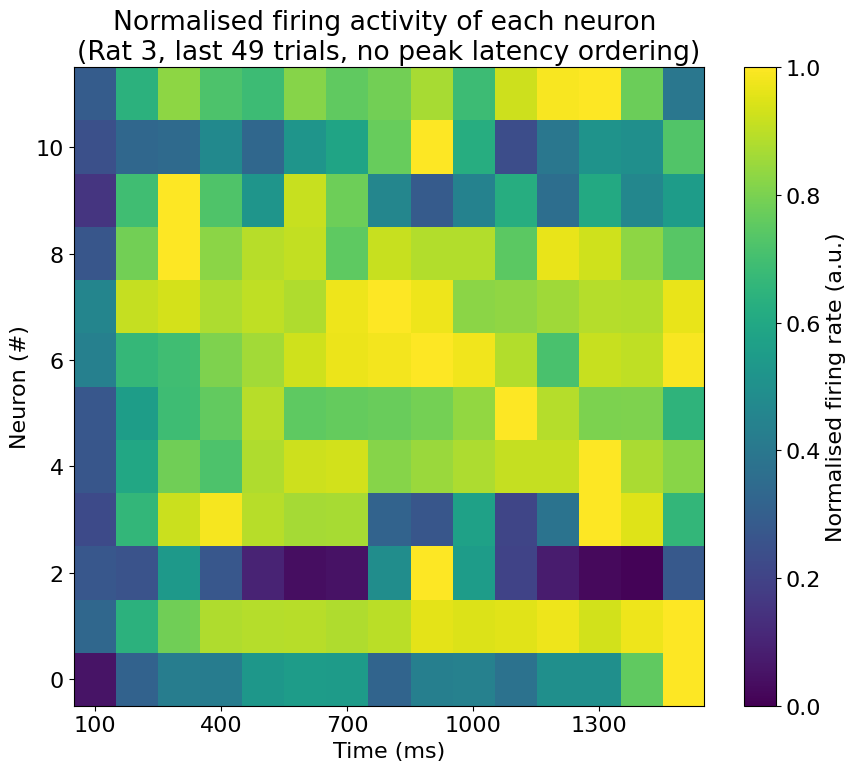

In [68]:
plot_identification = f'last {trials_in_thirds} trials, no peak latency ordering)' #trial segment, ordering
plot_trial_firing_rates(norm_last_mean_convolved,trial_index=0,show_peak=False,order_latencies=False,show_entropic_bins=False,
                            num_entropic_bins=15,lower_time_resolution=True,normalize_each_neuron=True,title_complement=title_complement_baseline+plot_identification)

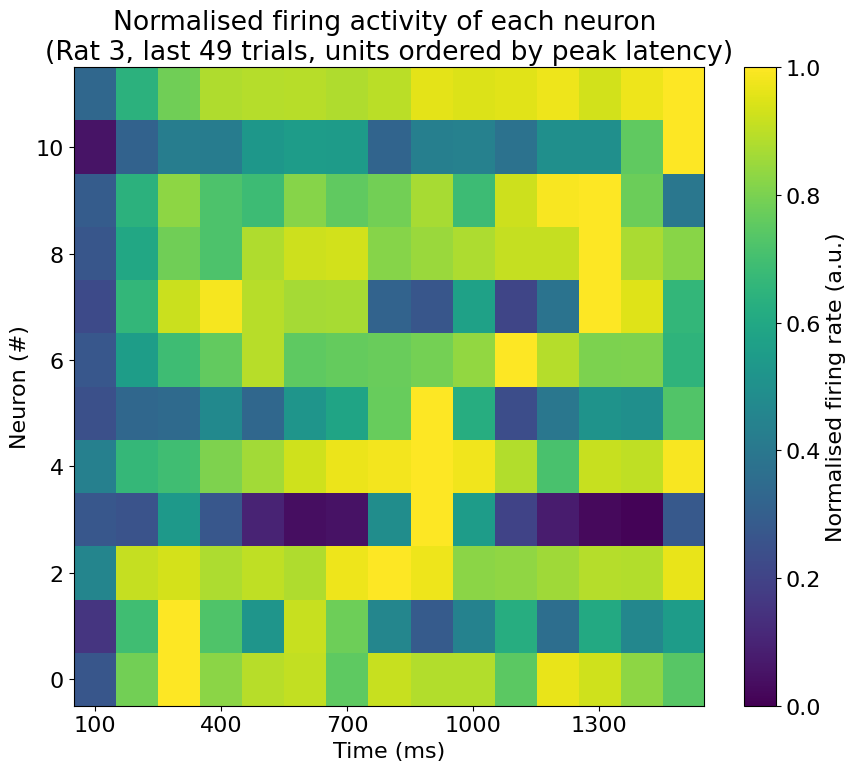

In [70]:
plot_identification = f'last {trials_in_thirds} trials, units ordered by peak latency)' #trial segment, ordering
#print('Last third of trials, units ordered by peak latency')
plot_trial_firing_rates(norm_last_mean_convolved,trial_index=0,show_peak=False,order_latencies=True,show_entropic_bins=False,
                            num_entropic_bins=15,lower_time_resolution=True,normalize_each_neuron=True,title_complement=title_complement_baseline+plot_identification)

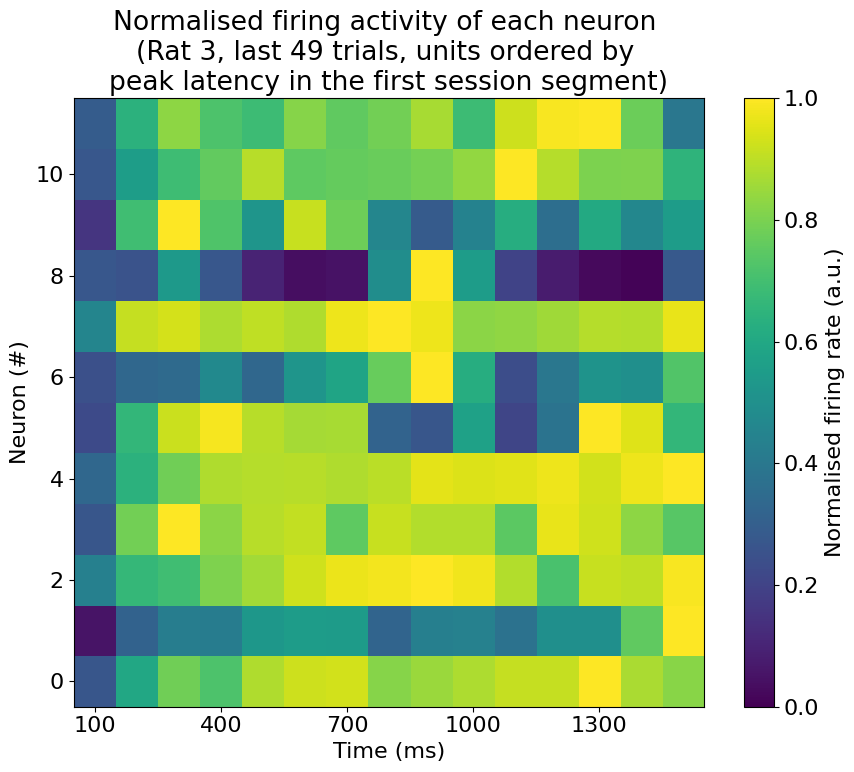

In [75]:
first_trials_ordering = peak_latency_ordering(norm_first_mean_convolved[0,:,:])

plot_identification = f'last {trials_in_thirds} trials, units ordered by \npeak latency in the first session segment)' #trial segment, ordering
plot_trial_firing_rates(norm_last_mean_convolved,trial_index=0,show_peak=False,order_latencies=True,show_entropic_bins=False,
                            num_entropic_bins=15,lower_time_resolution=True,normalize_each_neuron=True,
                        specific_neuron_ordering=first_trials_ordering,title_complement=title_complement_baseline+plot_identification)